# Contraceptive Data: Predicting Number of Children 

### Authors: 
Brandon Chu, Emily Pham, Rosetta Wang 

### In This Project:
We will be using the contraceptive data set which was conducted on a set of married women (who were not pregnant at the time) from Indonesia in 1987. It contains information about their background (e.g. age, number of children, education) and the type of contraceptive they used at the time.

Our research explores the question "What are the factors that best determine the number of children that a woman has?"

We will perform exploratory data analysis (EDA) and build a model to try answering that question. 

### Loading the Data and Importing Libraries 

In [201]:
import csv
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import math

In [202]:
data = pd.read_csv("contraceptive_for_students.csv")

#Display data
data.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


## Contextualizing the Data Set 

Using data from Gapminder, we will contextualize Indonesia in relation to other countries in the world. 

In [203]:
# import data 
fertility_and_contraception_df = pd.read_csv('fertility-vs-contraception.csv')
# filter to only include data where the year is 1987 and there are no null values 
filtered_f_and_c = fertility_and_contraception_df[(fertility_and_contraception_df.Year == 1987) & pd.notnull(
    fertility_and_contraception_df.iloc[:,4])]
filtered_f_and_c[filtered_f_and_c.Entity=='Indonesia']

,Entity,Code,Year,Fertility rate (births per woman) (births per woman),"Contraceptive prevalence, any methods (% of women aged 15-49) (% of women aged 15-49)"
5807,Indonesia,IDN,1987,3.472,47.7


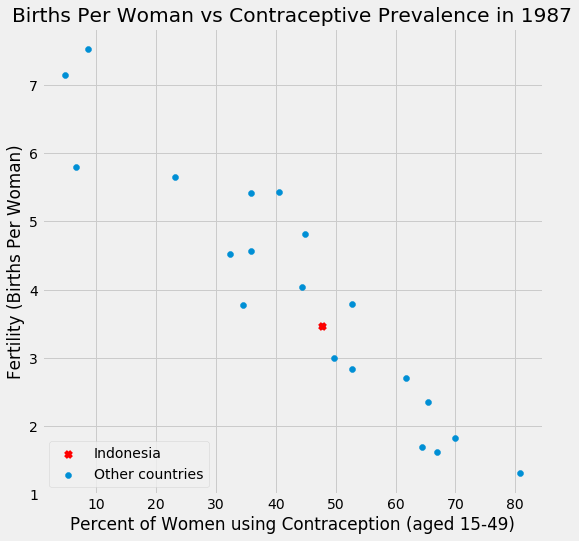

In [204]:
plt.figure(figsize=(8, 8))

# Indonesia's x and y values 
IDN_x = [47.7]
IDN_y = [3.472]

# create scatter plot 
other_countries = plt.scatter(filtered_f_and_c.iloc[:,4], filtered_f_and_c.iloc[:,3])
IDN = plt.scatter(IDN_x, IDN_y, marker='x', color='r')
plt.title("Births Per Woman vs Contraceptive Prevalence in 1987")
plt.xlabel('Percent of Women using Contraception (aged 15-49)')
plt.ylabel('Fertility (Births Per Woman)')
plt.legend((IDN, other_countries), ('Indonesia', 'Other countries'),
           scatterpoints=1,
           loc='lower left')

In [205]:
# import data 
fertility_and_laborforce_df = pd.read_csv('fertility-and-female-labor-force-participation.csv')
# filter to only include data where the year is 1987 and there are no null values 
filtered_f_and_lf = fertility_and_laborforce_df[(fertility_and_laborforce_df.Year == '1987') & pd.notnull(
    fertility_and_laborforce_df.iloc[:,4])]
filtered_f_and_lf[filtered_f_and_lf.Entity=='Indonesia']

,Entity,Code,Year,Fertility (live births per woman) (live births per woman),Female labor force participation rate (%) (% of female population ages 15+ national estimate),Total population (Gapminder)


In [206]:
# Because there is no data for female labor force participation rate in Indonesia in 1987, we will examine 1988
# filter to only include data where the year is 1988 and there are no null values 
filtered_f_and_lf = fertility_and_laborforce_df[(fertility_and_laborforce_df.Year == '1988') & pd.notnull(
    fertility_and_laborforce_df.iloc[:,4])]
filtered_f_and_lf[filtered_f_and_lf.Entity=='Indonesia']

,Entity,Code,Year,Fertility (live births per woman) (live births per woman),Female labor force participation rate (%) (% of female population ages 15+ national estimate),Total population (Gapminder)
19604,Indonesia,IDN,1988,3.346,54.240002,174976000.0


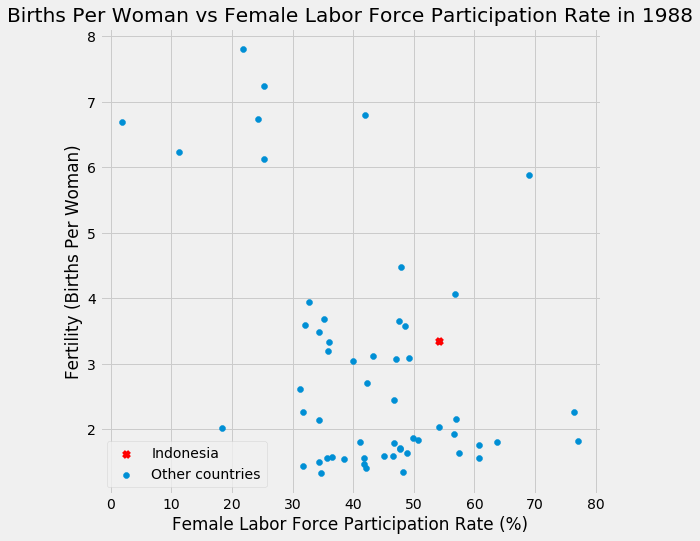

In [207]:
plt.figure(figsize=(8, 8))

# Indonesia's x and y values 
IDN_x = [54.240002]
IDN_y = [3.346]

# create scatter plot 
others = plt.scatter(filtered_f_and_lf.iloc[:,4], filtered_f_and_lf.iloc[:,3])
IDN = plt.scatter(IDN_x, IDN_y, marker='x', color='r')
plt.title("Births Per Woman vs Female Labor Force Participation Rate in 1988")
plt.xlabel('Female Labor Force Participation Rate (%)')
plt.ylabel('Fertility (Births Per Woman)')
plt.legend((IDN, others), ('Indonesia', 'Other countries'),
           scatterpoints=1,
           loc='lower left')

The first scatterplot shows that rate of contraceptive use in a population is negatively correlated with births per woman. The country's stage of development is a confounding factor that contributes to the correction between the number of women in the work force and births per women. The two plots have a different number of points because only countries with data in the given years are included.

## Exploratory Data Analysis 

Before modeling the data, we first conduct exploratory data analysis to summarize the data's main characteristics.

From the UCI Machine Learning Repository, we get the following information about each of the variables:

1. `wife_age`: (numerical)
2. `wife_education`: (categorical) 1=low, 2, 3, 4=high
3. `husband_eduation`: (categorical) 1=low, 2, 3, 4=high
4. `num_child`: (numerical)
5. `wife_religion`: (binary) 0=Non-Islam, 1=Islam
6. `wife_work`: (binary) 0=Yes, 1=No
7. `husband_occupation`: (categorical) 1, 2, 3, 4
8. `standard_living`: (categorical) 1=low, 2, 3, 4=high
9. `media_exposure`: (binary) 0=Good, 1=Not good
10. `contraceptive`: (class attribute) 1=No-use, 2=Long-term, 3=Short-term

In [208]:
# Shape of data
data.shape

(1473, 10)

In [209]:
# Finding number of null values
data.isnull().sum()

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

There are 1473 women in our dataset. 
There aren't any null values. 

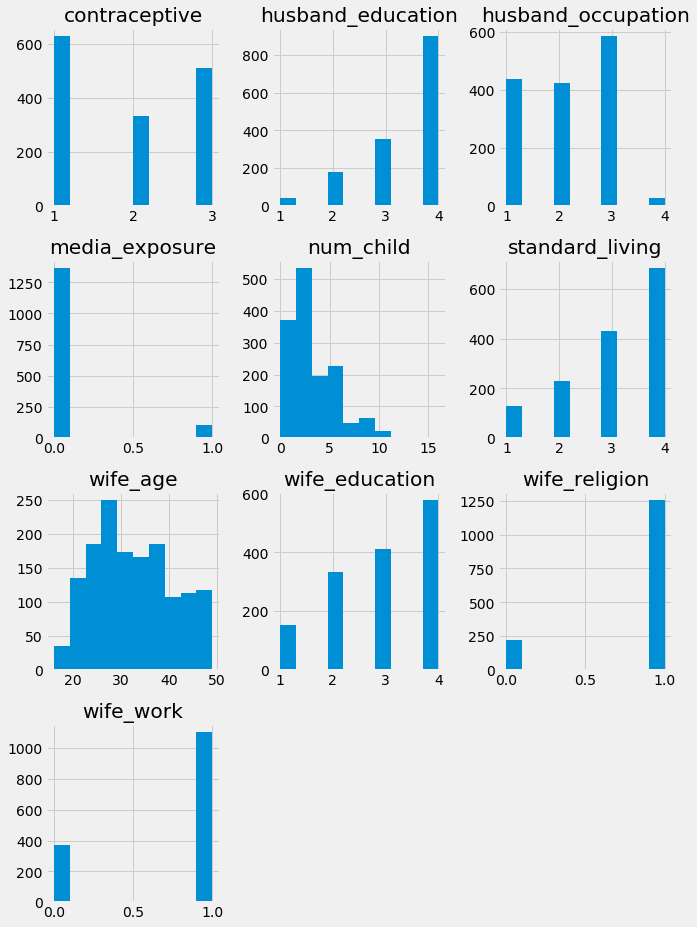

In [210]:
# Create histograms of numerical variables
data.hist(figsize = (10, 15));

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
wife_age,1.000000,-0.048011,-0.052879,0.540126,-0.139543,-0.039880,-0.202532,0.184485,0.113306,-0.162953
wife_education,-0.048011,1.000000,0.618369,-0.193839,-0.232973,-0.062200,-0.395921,0.361450,-0.336080,0.149777
husband_education,-0.052879,0.618369,1.000000,-0.187513,-0.178447,0.001099,-0.337003,0.357490,-0.288691,0.103226
num_child,0.540126,-0.193839,-0.187513,1.000000,0.073917,0.097316,-0.023000,-0.006046,0.133658,0.082772
wife_religion,-0.139543,-0.232973,-0.178447,0.073917,1.000000,0.069837,0.084417,-0.196308,0.060243,-0.025271
wife_work,-0.039880,-0.062200,0.001099,0.097316,0.069837,1.000000,0.014232,-0.076505,0.001828,0.054438
husband_occupation,-0.202532,-0.395921,-0.337003,-0.023000,0.084417,0.014232,1.000000,-0.293831,0.113925,0.018161
standard_living,0.184485,0.361450,0.357490,-0.006046,-0.196308,-0.076505,-0.293831,1.000000,-0.251359,0.091149
media_exposure,0.113306,-0.336080,-0.288691,0.133658,0.060243,0.001828,0.113925,-0.251359,1.000000,-0.119206
contraceptive,-0.162953,0.149777,0.103226,0.082772,-0.025271,0.054438,0.018161,0.091149,-0.119206,1.000000


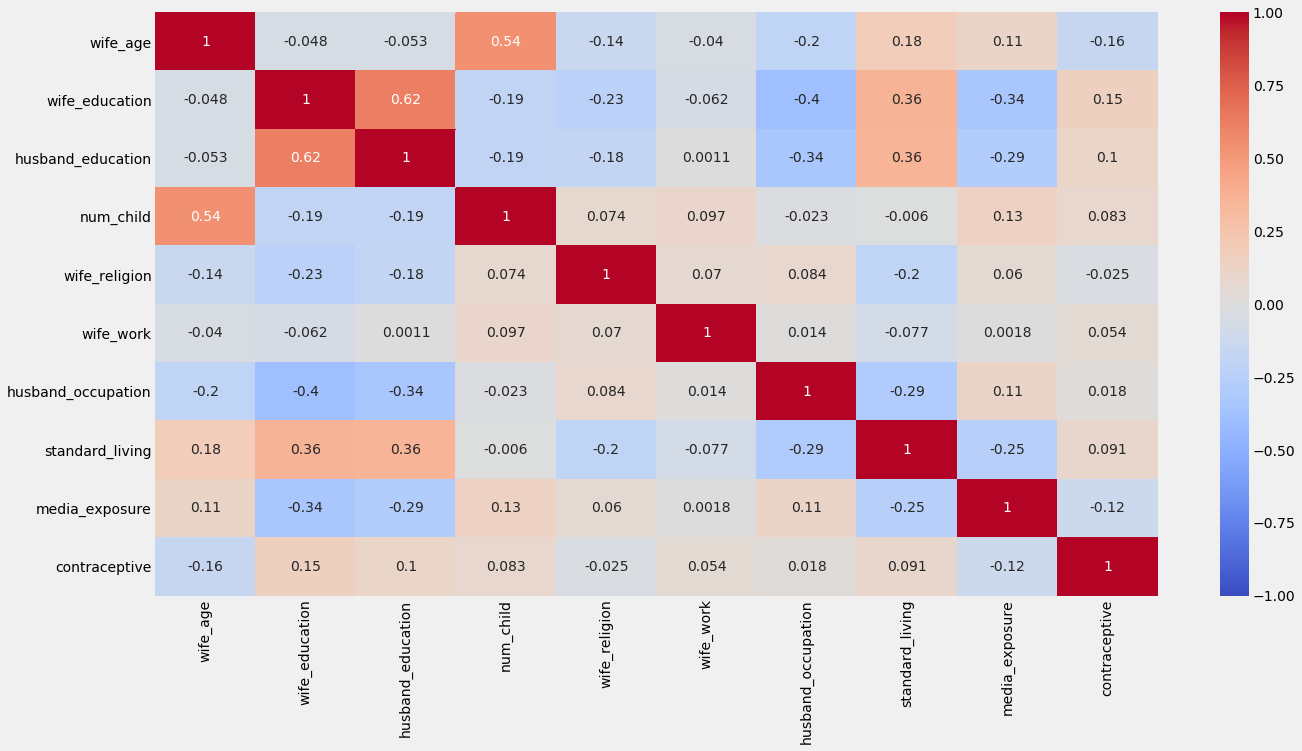

In [211]:
# Create heatmap to visualize correlation between variables.
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr(), annot = True, cmap='coolwarm', vmin=-1, vmax=1, center= 0)
data.corr()

From the heat map, it appears that the variable we are trying to predict, number of children, has the strongest correlation with wife age. 

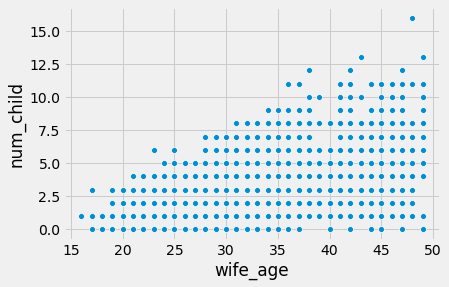

In [212]:
# Visualize the relationship between number of children and wife age
sns.scatterplot(x='wife_age', y='num_child', data=data)

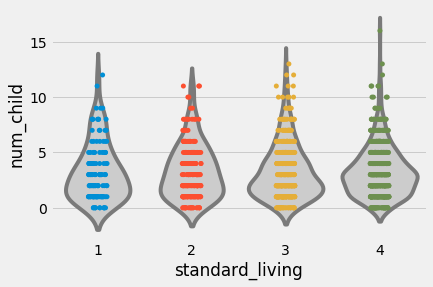

In [213]:
sns.violinplot(x = "standard_living", y = "num_child", data = data, inner = None, color = "0.8")
sns.stripplot(x = "standard_living", y = "num_child", data = data, jitter = True);


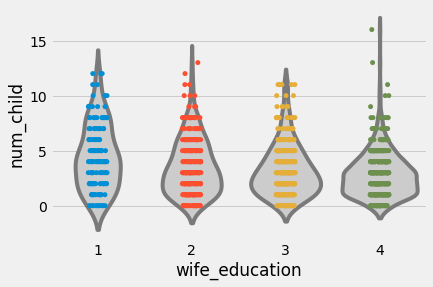

In [214]:
sns.violinplot(x = "wife_education", y = "num_child", data = data, inner = None, color = "0.8")
sns.stripplot(x = "wife_education", y = "num_child", data = data, jitter = True);


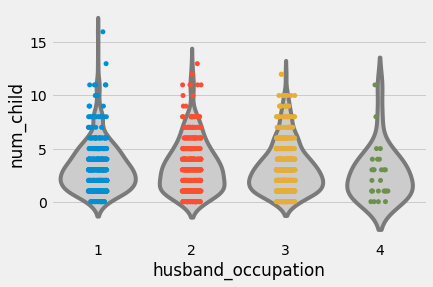

In [215]:
sns.violinplot(x = "husband_occupation", y = "num_child", data = data, inner = None, color = "0.8")
sns.stripplot(x = "husband_occupation", y = "num_child", data = data, jitter = True);

The heat map shows that the strongest correlation between any two variables is between wife education and husband education. Let's further explore these variables.

In [216]:
data.wife_education.value_counts()

4    577
3    410
2    334
1    152
Name: wife_education, dtype: int64

In [217]:
data.husband_education.value_counts()

4    899
3    352
2    178
1     44
Name: husband_education, dtype: int64

In [218]:
w_edu_higher_than_or_equal_to_h = data[data['wife_education']>=data['husband_education']]

number_of_w_with_higher_or_equal_edu = w_edu_higher_than_or_equal_to_h.shape[0]
print(f"In this dataset, there are {number_of_w_with_higher_or_equal_edu} wives who have an education that is higher than or equal to their husbands")
print(f"That means that {(data.shape[0]-number_of_w_with_higher_or_equal_edu)/data.shape[0]}% of the women have a lower educational level than their husbands")

In this dataset, there are 884 wives who have an education that is higher than or equal to their husbands
That means that 0.3998642226748133% of the women have a lower educational level than their husbands


This dataset has 3 binary variables: wife_religion, wife_work, and media_exposure. Let's examine the distribution of these variables.

In [219]:
data.wife_religion.value_counts()

1    1253
0     220
Name: wife_religion, dtype: int64

In [220]:
data.wife_work.value_counts()

1    1104
0     369
Name: wife_work, dtype: int64

In [221]:
data.media_exposure.value_counts()

0    1364
1     109
Name: media_exposure, dtype: int64

Something to consider when building our model, is that these because these binary variables are largely disproportionate, this makes feature...

## Train-Test Split

We now split the data into a train and test dataset, with 90% in `train` and 10% in `test`.

In [222]:
np.random.seed(seed = 100)

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.1)

In [223]:
print(len(train) + len(test) == len(data))

True


## Cross Validation

We now set up the cross validation step for our model. We will use five-fold cross validation.

In [224]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

In [225]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone

In [226]:
def cross_validate_rmse(model):
    model = clone(model)
    five_fold = KFold(n_splits = 5)
    rmse_values = []
    for train_ind, val_ind in five_fold.split(train):
        model.fit(train.iloc[train_ind,:], train["num_child"].iloc[train_ind])
        rmse_values.append(rmse(train["num_child"].iloc[val_ind], model.predict(train.iloc[val_ind,:])))
    return np.mean(rmse_values)

## Linear Models

We now construct linear regression models for number of children.

In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

In [228]:
data_corr = data.corr()
data_corr = data_corr.iloc[(-data_corr["num_child"].abs()).argsort()].reset_index()
data_corr = data_corr.drop([0, 1])

In [229]:
categorical = data_corr["index"].to_numpy()
categorical

array(['wife_education', 'husband_education', 'media_exposure',
       'wife_work', 'contraceptive', 'wife_religion',
       'husband_occupation', 'standard_living'], dtype=object)

In [230]:
models = {}

In [231]:
for i in range(len(categorical) + 1):
    features = categorical[:i]
    name = i
    model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", ["wife_age"]),
            ("origin_encoder", OneHotEncoder(), features)
        ])),
        ("LinearModel", LinearRegression())
    ])
    model.fit(train, train["num_child"]);
    models[name] = model

In [232]:
models.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [233]:
feature_names = np.append(["wife_age"], categorical)
feature_names

array(['wife_age', 'wife_education', 'husband_education',
       'media_exposure', 'wife_work', 'contraceptive', 'wife_religion',
       'husband_occupation', 'standard_living'], dtype=object)

#### Linear Model 1

In Model 1, we explore the linear relationship between `wife_age` and `num_child`, both numerical variables.

In [234]:
print(feature_names[0:1])

['wife_age']


In [235]:
models[0].fit(train, train["num_child"])
y_hat_1 = models[0].predict(train)
y_1 = train["num_child"]
print("Linear model 1 train error:", rmse(y_1, y_hat_1))

Linear model 1 train error: 1.9754947408235202


In [236]:
print("Linear model 1 cross validation error:", cross_validate_rmse(models[0]))

Linear model 1 cross validation error: 1.974357114805289


#### Linear Model 2 
In Model 2, we begin to add categorical variables

In [237]:
print(feature_names[0:2])

['wife_age' 'wife_education']


In [238]:
models[1].fit(train, train["num_child"])
y_hat_2 = models[1].predict(train)
y_2 = train["num_child"]
print("Linear model 2 train error:", rmse(y_2, y_hat_2))

Linear model 2 train error: 1.9266510613418515


In [239]:
print("Linear model 2 cross validation error:", cross_validate_rmse(models[1]))

Linear model 2 cross validation error: 1.9336644837295054


#### Linear Model 3

In [240]:
print(feature_names[0:3])

['wife_age' 'wife_education' 'husband_education']


In [241]:
models[2].fit(train, train["num_child"])
y_hat_3 = models[2].predict(train)
y_3 = train["num_child"]
print("Linear model 3 train error:", rmse(y_3, y_hat_3))

Linear model 3 train error: 1.9168949089061025


In [242]:
print("Linear model 3 cross validation error:", cross_validate_rmse(models[2]))

Linear model 3 cross validation error: 1.9261524300371096


#### Linear Model 4

In [243]:
print(feature_names[0:4])

['wife_age' 'wife_education' 'husband_education' 'media_exposure']


In [244]:
models[3].fit(train, train["num_child"])
y_hat_4 = models[3].predict(train)
y_4 = train["num_child"]
print("Linear model 4 train error:", rmse(y_4, y_hat_4))

Linear model 4 train error: 1.9145683480354083


In [245]:
print("Linear model 4 cross validation error:", cross_validate_rmse(models[3]))

Linear model 4 cross validation error: 1.9243955849924645


#### Linear Model 5

In [246]:
print(feature_names[0:5])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work']


In [247]:
models[4].fit(train, train["num_child"])
y_hat_5 = models[4].predict(train)
y_5 = train["num_child"]
print("Linear model 5 train error:", rmse(y_5, y_hat_5))

Linear model 5 train error: 1.897767345047242


In [248]:
print("Linear model 5 cross validation error:", cross_validate_rmse(models[4]))

Linear model 5 cross validation error: 1.9086380192544745


#### Linear Model 6

In [249]:
print(feature_names[0:6])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive']


In [250]:
models[5].fit(train, train["num_child"])
y_hat_6 = models[5].predict(train)
y_6 = train["num_child"]
print("Linear model 6 train error:", rmse(y_6, y_hat_6))

Linear model 6 train error: 1.8228020910032234


In [251]:
print("Linear model 6 cross validation error:", cross_validate_rmse(models[5]))

Linear model 6 cross validation error: 1.8355289837824535


#### Linear Model 7

In [252]:
print(feature_names[0:7])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive' 'wife_religion']


In [253]:
models[6].fit(train, train["num_child"])
y_hat_7 = models[6].predict(train)
y_7 = train["num_child"]
print("Linear model 7 train error:", rmse(y_7, y_hat_7))

Linear model 7 train error: 1.802704209872939


In [254]:
print("Linear model 7 cross validation error:", cross_validate_rmse(models[6]))

Linear model 7 cross validation error: 1.8149594456260623


#### Linear Model 8

In [255]:
print(feature_names[0:8])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive' 'wife_religion' 'husband_occupation']


In [256]:
models[7].fit(train, train["num_child"])
y_hat_8 = models[7].predict(train)
y_8 = train["num_child"]
print("Linear model 8 train error:", rmse(y_8, y_hat_8))

Linear model 8 train error: 1.7997161869072535


In [257]:
print("Linear model 8 cross validation error:", cross_validate_rmse(models[7]))

Linear model 8 cross validation error: 1.8143215621191875


#### Linear Model 9

In [258]:
print(feature_names[0:9])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive' 'wife_religion' 'husband_occupation'
 'standard_living']


In [259]:
models[8].fit(train, train["num_child"])
y_hat_9 = models[8].predict(train)
y_9 = train["num_child"]
print("Linear model 9 train error:", rmse(y_9, y_hat_9))

Linear model 9 train error: 1.7980986486297792


In [260]:
print("Linear model 9 cross validation error:", cross_validate_rmse(models[8]))



Linear model 9 cross validation error: 1.8155616066911926


#### Linear Model: Graph of Errors

In [261]:
import plotly.graph_objects as go

In [262]:
def compare_models(models):
    # Compute the training error for each model
    training_rmse = [rmse(train["num_child"], model.predict(train)) for model in models.values()]
    
    # Compute the cross validation error for each model
    validation_rmse = [cross_validate_rmse(model) for model in models.values()]
    
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        go.Bar(x = names, y = validation_rmse, name="CV RMSE")])
    fig.update_yaxes(title="RMSE")
    return fig

In [263]:
compare_models(models)

## Tree Regression
We now construct tree regression models for number of children using a similar method to what was used to create our linear models

In [264]:
tree_models = {}

In [265]:
for i in range(len(categorical) + 1):
    features = categorical[:i]
    name = i
    tree_model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", ["wife_age"]),
            ("origin_encoder", OneHotEncoder(), features)
        ])),
        ("TreeModel", DecisionTreeRegressor())
    ])
    tree_model.fit(train, train["num_child"]);
    tree_models[name] = tree_model

In [266]:
tree_models.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

#### Tree Regression Model 1

In [267]:
print(feature_names[0:1])

['wife_age']


In [268]:
tree_models[0].fit(train, train["num_child"])
y_hat_tree_1 = tree_models[0].predict(train)
y_tree_1 = train["num_child"]
print("Tree regression model 1 train error:", rmse(y_tree_1, y_hat_tree_1))

Tree regression model 1 train error: 1.934668351749654


In [269]:
print("Tree regression model 1 cross validation error:", cross_validate_rmse(tree_models[0]))

Tree regression model 1 cross validation error: 1.9937739711956435


#### Tree Regression Model 2

In [270]:
print(feature_names[0:2])

['wife_age' 'wife_education']


In [271]:
tree_models[1].fit(train, train["num_child"])
y_hat_tree_2 = tree_models[1].predict(train)
y_tree_2 = train["num_child"]
print("Tree regression model 2 train error:", rmse(y_tree_2, y_hat_tree_2))

Tree regression model 2 train error: 1.7740694851494414


In [272]:
print("Tree regression model 2 cross validation error:", cross_validate_rmse(tree_models[1]))

Tree regression model 2 cross validation error: 2.052804306756869


#### Tree Regression Model 3 

In [273]:
print(feature_names[0:3])

['wife_age' 'wife_education' 'husband_education']


In [274]:
tree_models[2].fit(train, train["num_child"])
y_hat_tree_3 = tree_models[2].predict(train)
y_tree_3 = train["num_child"]
print("Tree regression model 3 train error:", rmse(y_tree_3, y_hat_tree_3))

Tree regression model 3 train error: 1.54670380402933


In [275]:
print("Tree regression model 3 cross validation error:", cross_validate_rmse(tree_models[2]))

Tree regression model 3 cross validation error: 2.221381877758218


#### Tree Regression Model 4


In [276]:
print(feature_names[0:4])

['wife_age' 'wife_education' 'husband_education' 'media_exposure']


In [277]:
tree_models[3].fit(train, train["num_child"])
y_hat_tree_4 = tree_models[3].predict(train)
y_tree_4 = train["num_child"]
print("Tree regression model 4 train error:", rmse(y_tree_4, y_hat_tree_4))

Tree regression model 4 train error: 1.4786051858199631


In [278]:
print("Tree regression model 4 cross validation error:", cross_validate_rmse(tree_models[3]))




Tree regression model 4 cross validation error: 2.3026907169161768


#### Tree Regression Model 5

In [279]:
print(feature_names[0:5])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work']


In [280]:
tree_models[4].fit(train, train["num_child"])
y_hat_tree_5 = tree_models[4].predict(train)
y_tree_5 = train["num_child"]
print("Tree regression model 5 train error:", rmse(y_tree_5, y_hat_tree_5))

Tree regression model 5 train error: 1.320247520536179


In [281]:
print("Tree regression model 5 cross validation error:", cross_validate_rmse(tree_models[4]))

Tree regression model 5 cross validation error: 2.3333218850352013


#### Tree Regression Model 6 

In [282]:
print(feature_names[0:6])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive']


In [283]:
tree_models[5].fit(train, train["num_child"])
y_hat_tree_6 = tree_models[5].predict(train)
y_tree_6 = train["num_child"]
print("Tree regression model 6 train error:", rmse(y_tree_6, y_hat_tree_6))

Tree regression model 6 train error: 0.9892678068403893


In [284]:
print("Tree regression model 6 cross validation error:", cross_validate_rmse(tree_models[5]))

Tree regression model 6 cross validation error: 2.354345517111395


#### Tree Regression Model 7

In [285]:
print(feature_names[0:7])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive' 'wife_religion']


In [286]:
tree_models[6].fit(train, train["num_child"])
y_hat_tree_7 = tree_models[6].predict(train)
y_tree_7 = train["num_child"]
print("Tree regression model 7 train error:", rmse(y_tree_7, y_hat_tree_7))

Tree regression model 7 train error: 0.8912119613805779


In [287]:
print("Tree regression model 7 cross validation error:", cross_validate_rmse(tree_models[6]))

Tree regression model 7 cross validation error: 2.3224209430323004


#### Tree Regression Model 8 

In [288]:
print(feature_names[0:8])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive' 'wife_religion' 'husband_occupation']


In [289]:
tree_models[7].fit(train, train["num_child"])
y_hat_tree_8 = tree_models[7].predict(train)
y_tree_8 = train["num_child"]
print("Tree regression model 8 train error:", rmse(y_tree_8, y_hat_tree_8))

Tree regression model 8 train error: 0.5936667849663876


In [290]:
print("Tree regression model 8 cross validation error:", cross_validate_rmse(tree_models[7]))

Tree regression model 8 cross validation error: 2.5125794935399375


#### Tree Regression Model 9 


In [291]:
print(feature_names[0:9])

['wife_age' 'wife_education' 'husband_education' 'media_exposure'
 'wife_work' 'contraceptive' 'wife_religion' 'husband_occupation'
 'standard_living']


In [292]:
tree_models[8].fit(train, train["num_child"])
y_hat_tree_9 = tree_models[8].predict(train)
y_tree_9 = train["num_child"]
print("Tree regression model 9 train error:", rmse(y_tree_9, y_hat_tree_9))

Tree regression model 9 train error: 0.4249306269685077


In [293]:
print("Tree regression model 9 cross validation error:", cross_validate_rmse(tree_models[8]))

Tree regression model 9 cross validation error: 2.5668983633607825


#### Tree Regression: Graph of Errors

In [294]:
compare_models(tree_models)